# **Projeto Determinação de Tamanho de Grãos**
### Um projeto da IEEE Computer Society UFABC + Electronics Packaging Society UFABC

Esse projeto consiste na utilização de técnicas de Processamento de Imagens para realizar a determinação de tamanho de grão para imagens de micrografia de metais. Essa tarefa é atualmente realizada manualmente por todos os estudantes de Engenharia na UFABC, em especial os de Engenharia de Materias. O objetivo final é a criação de um site que realize essa tarefa automaticamente e com precisão.
___
### Para utilizar este projeto, clique em *show widgets* e aguarde.

In [1]:
#nbi:hide_in
#Bibliotecas
import cv2
import numpy as np
import matplotlib.pyplot as plt

from io import BytesIO
from PIL import Image
from IPython.display import FileLink

import ipywidgets as widgets
from ipywidgets import interact
import nbinteract as nbi
import time

show = True
binder = True
n_real = 0

In [2]:
#nbi:hide_in
def getCircle(n):
    '''kernel has size NxN'''
    # xx and yy are 200x200 tables containing the x and y coordinates as values
    # mgrid is a mesh creation helper
    xx, yy = np.mgrid[:n,:n]
    # circles contains the squared distance to the (100, 100) point
    # we are just using the circle equation learnt at school
    circle = (xx - np.floor(n/2)) ** 2 + (yy - np.floor(n/2)) ** 2
    circle = circle<=np.max(circle)*.5
    circle = np.uint8(circle)
    return circle

def processing(img):
    '''
    return img_contours, img_borders, img_colored, resultado, erro
    '''
    #Conversão de uma imagem para outro sistema de cores
    img_gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    #Adaptivo
    img_thresh = cv2.adaptiveThreshold(img_gray, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 199, 3) 

    #Fechamento
    kernel = getCircle(3)
    img_open = cv2.morphologyEx(img_thresh,cv2.MORPH_CLOSE,kernel, iterations = 0)
    img_open = cv2.erode(img_open, kernel, iterations=3)
    #print("dtype=", img_open.dtype)

    #Desenhando borda na imagem
    y,x = img_open.shape
    #print(img_open.dtype)
    color = 0
    img_open[:,   0] = 0; img_open[:, x-1] = 0; img_open[0,   :] = 0; img_open[y-1, :] = 0

    #Gerando Lista de Contornos
    cv2MajorVersion = cv2.__version__.split(".")[0]
    if int(cv2MajorVersion) >= 4:
        contours, _= cv2.findContours(img_open,cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    else:
        _, contours, _ = cv2.findContours(img_open,cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    #Ordenando Lista de Contornos de acordo com a área
    contours = sorted(contours, key = cv2.contourArea, reverse = True)
    #print("n_contours_before =", len(contours))

    #Selecionando apenas contornos cuja área é maior que algum valor
    min_area = 20.0
    contours = [c for c in contours if cv2.contourArea(c)>min_area]
    #print("n_contours_after =", len(contours))

    #Desenhando Contornos na imagem original
    verde = (0,255,0)
    img_contours = cv2.drawContours(img.copy(), contours, -1, verde, 3)

    #Separando grãos das bordas
    faixa = 3
    n_borda = 0
    img_borders = np.int32(np.ones(img.shape))
    red = [0,255,0]
    blue = [255,0,0]
    for c in contours:
        (x_ini,y_ini,w,h) = cv2.boundingRect(c)
        x_end = x_ini+w; y_end = y_ini+h
        y_img, x_img = img_thresh.shape

        if 0<x_ini<faixa or 0<y_ini<faixa or x_img-faixa<x_end<x_img or y_img-faixa<y_end<y_img:
            n_borda +=1
            random_red = [np.random.randint(20, 235) for i in range(3)]
            random_red[0] = 255
            img_borders = cv2.fillPoly(img_borders, [c], random_red)
        else:
            random_blue = [np.random.randint(20, 235) for i in range(3)]
            random_blue[1] = 255
            img_borders = cv2.fillPoly(img_borders, [c], random_blue)
    #print(n_borda)

    #Preenchendo contornos
    img_colored = np.int32(np.ones(img.shape))
    img_out = img.copy()
    for c in contours:
        random_color = [np.random.randint(20, 235) for i in range(3)]
        img_colored = cv2.fillPoly(img_colored, [c], random_color)
        img_out = cv2.drawContours(img_out, [c], -1, random_color, 3)
    
    #resultados
    #print("n_contours =", len(contours))
    #print("n_borda =", n_borda)
    resultado = len(contours)-round(n_borda/2)
    #print("resultado =", resultado, "grãos")
    erro=0
    if n_real>0:
        #print("n_real =", n_real)
        erro = abs(n_real-resultado)
        #print("erro =", erro)
    
    return img_contours, img_borders, img_colored, img_out, resultado, erro

### Faça upload da imagem desejada.

In [4]:
#nbi:hide_in
#Upload da imagem
uploader = widgets.FileUpload()
display(uploader)

FileUpload(value={}, description='Upload')

### Arraste o botão abaixo para conferir que a imagem selecionada foi corretamente enviada.

In [15]:
#nbi:hide_in
#Conversão da imagem e display inicial
img = np.ones([5,5])
def convert(mostrar):
    global img
    if mostrar:
        [uploaded_file] = list(uploader.value)
        binary = uploader.value[uploaded_file]['content']
        img = Image.open(BytesIO(binary))
        img = np.asarray(img)
        
        plt.figure(figsize=(10,10))
        plt.axis('off')
        plt.imshow(img, 'gray')
        return plt.show()
    else:
        return 0
interact(convert, mostrar=(0,1));

interactive(children=(IntSlider(value=0, description='mostrar', max=1), Output()), _dom_classes=('widget-inter…

### Arraste o botão abaixo para obter os resultados.

In [16]:
#nbi:hide_in
#Processamento principal
img_out = img.copy()
def results(mostrar):
    global img,img_out
    if mostrar:
        img_contours, img_borders, img_colored, img_out, resultado, erro = processing(img)
        
        print("Resultado = {} grãos contados".format(resultado))
        if n_real>0: print("Erro = {} grãos".format(erro))
        
        plt.figure(figsize=(10,10))
        plt.axis('off')
        plt.imshow(img_out, 'gray')
        return plt.show()
    else:
        return 0
interact(results, mostrar=(0,1));

interactive(children=(IntSlider(value=0, description='mostrar', max=1), Output()), _dom_classes=('widget-inter…

### Se desejar, realize o download da clicando com o botão direito.

In [7]:
#nbi:hide_in
#nbi:hide_out

#Donload da imagem
def download(switch):
    if switch:
        filename = './img_out.jpg'
        cv2.imwrite(filename,img_out)
        local_file = FileLink(filename, result_html_prefix="Click here to download: ")
        return local_file
    else:
        return 0
interact(download, switch=(0,1));

interactive(children=(IntSlider(value=0, description='switch', max=1), Output()), _dom_classes=('widget-intera…

___
### O código utilizado no processamento é mostrado abaixo:

(1342, 1600, 3)


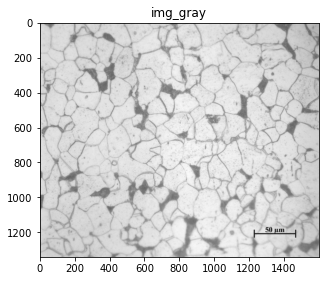

In [60]:
#Abrindo imagem
if binder:
    [uploaded_file] = list(uploader.value)
    binary = uploader.value[uploaded_file]['content']
    img = Image.open(BytesIO(binary))
    img = np.asarray(img)
else:
    img = plt.imread('data/aço 1010 50x - corrigido (1).jpg')
    img_thresh = cv2.adaptiveThreshold(img_gray, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 199, 3) 
    
print(img.shape)

#Conversão de uma imagem para outro sistema de cores
img_gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

#Visualização de imagem individual
if show: plt.figure(figsize=(5,5)); plt.title("img_gray"); fig = plt.imshow(img_gray, 'gray')

dtype= uint8


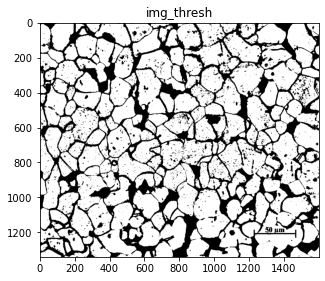

In [8]:
#Adaptivo
img_thresh = cv2.adaptiveThreshold(img_gray, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 199, 3) 
print("dtype=", img_thresh.dtype)
if show: plt.figure(figsize=(5,5)); plt.title("img_thresh"); fig = plt.imshow(img_thresh, 'gray')

dtype= uint8


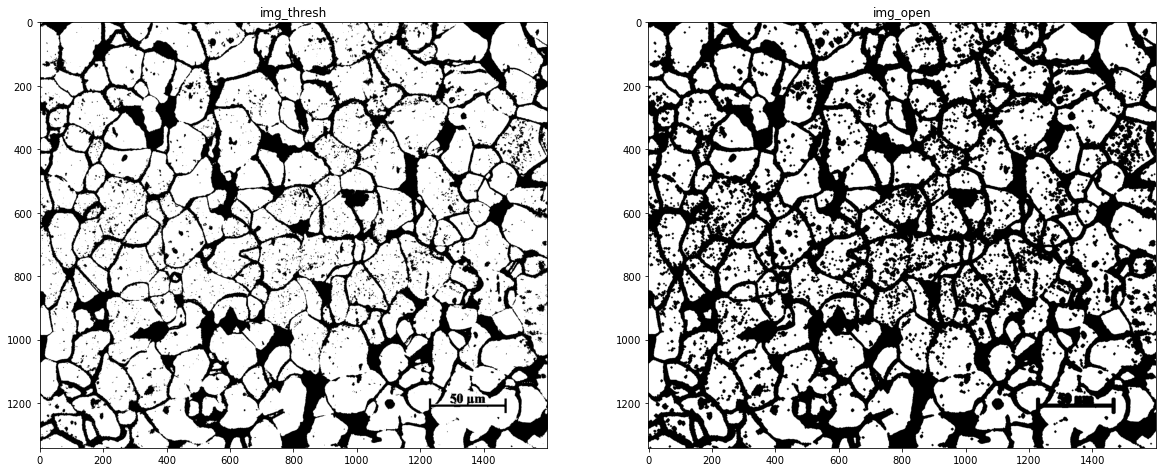

In [9]:
#Fechamento
def getCircle(n):
    '''kernel has size NxN'''
    # xx and yy are 200x200 tables containing the x and y coordinates as values
    # mgrid is a mesh creation helper
    xx, yy = np.mgrid[:n,:n]
    # circles contains the squared distance to the (100, 100) point
    # we are just using the circle equation learnt at school
    circle = (xx - np.floor(n/2)) ** 2 + (yy - np.floor(n/2)) ** 2
    circle = circle<=np.max(circle)*.5
    circle = np.uint8(circle)
    return circle

kernel = getCircle(3)
img_open = cv2.morphologyEx(img_thresh,cv2.MORPH_CLOSE,kernel, iterations = 0)
img_open = cv2.erode(img_open, kernel, iterations=3)
print("dtype=", img_open.dtype)

if show: plt.figure(figsize= (20,20))
if show: plt.subplot(121); plt.title('img_thresh'); fig=plt.imshow(img_thresh, 'gray')
if show: plt.subplot(122); plt.title('img_open'); fig=plt.imshow(img_open, 'gray')

uint8


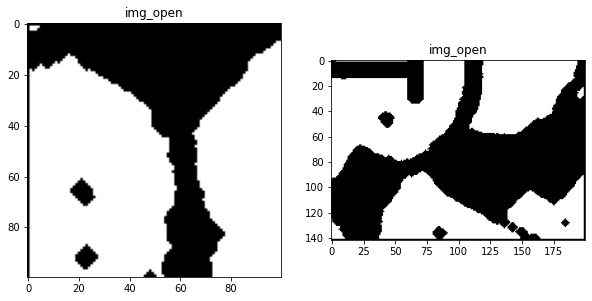

In [10]:
#Desenhando borda na imagem
y,x = img_open.shape
print(img_open.dtype)
color = 0
img_open[:,   0] = 0; img_open[:, x-1] = 0; img_open[0,   :] = 0; img_open[y-1, :] = 0

if show: plt.figure(figsize= (10,10))
if show: plt.subplot(121); plt.title('img_open'); fig = plt.imshow(img_open[:100,:100], 'gray')
if show: plt.subplot(122); plt.title('img_open'); fig = plt.imshow(img_open[1200:,1400:], 'gray')

n_contours_before = 449
n_contours_after = 237


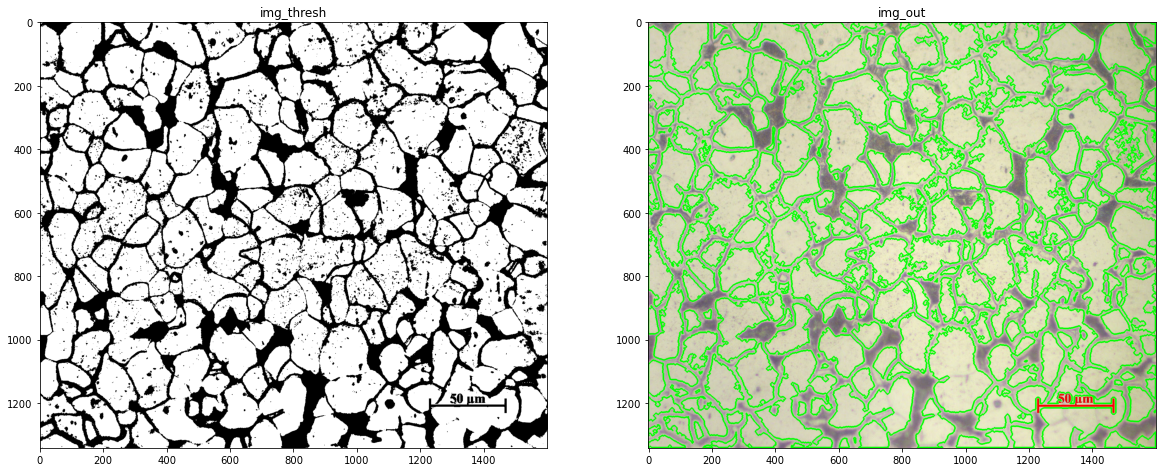

In [11]:
#Gerando Lista de Contornos
cv2MajorVersion = cv2.__version__.split(".")[0]
if int(cv2MajorVersion) >= 4:
    contours, _= cv2.findContours(img_open,cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
else:
    _, contours, _ = cv2.findContours(img_open,cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

#Ordenando Lista de Contornos de acordo com a área
contours = sorted(contours, key = cv2.contourArea, reverse = True)
print("n_contours_before =", len(contours))

#Selecionando apenas contornos cuja área é maior que algum valor
min_area = 20.0
contours = [c for c in contours if cv2.contourArea(c)>min_area]
print("n_contours_after =", len(contours))

#Desenhando Contornos na imagem original
verde = (0,255,0)
img_out = cv2.drawContours(img.copy(), contours, -1, verde, 3)

if show: plt.figure(figsize= (20,20))
if show: plt.subplot(121); plt.title('img_thresh'); fig=plt.imshow(img_thresh, 'gray')
if show: plt.subplot(122); plt.title('img_out'); fig=plt.imshow(img_out, 'gray')

55


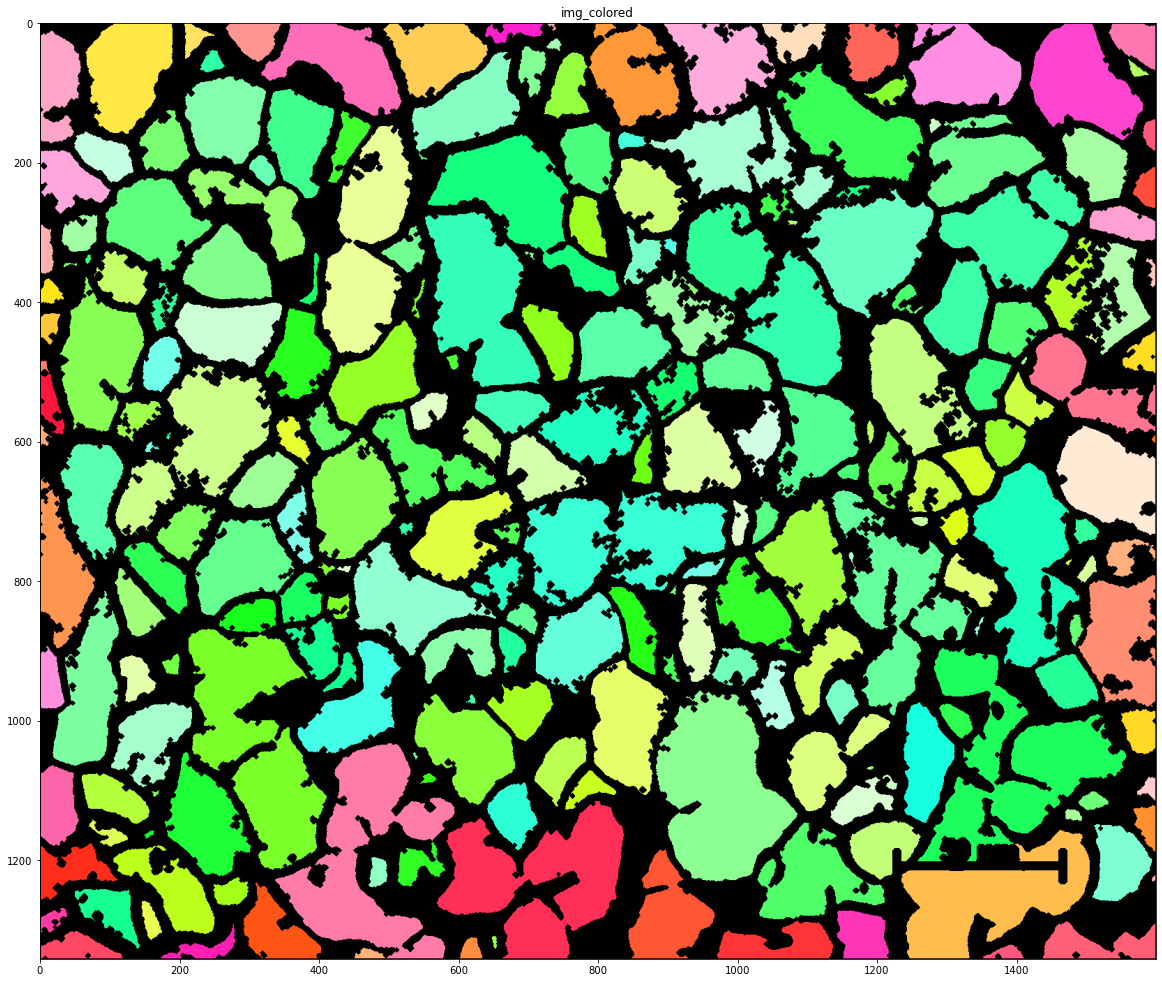

In [12]:
#Contagem de grãos na borda
faixa = 3
n_borda = 0
img_colored = np.int32(np.ones(img.shape))
red = [0,255,0]
blue = [255,0,0]
for c in contours:
    (x_ini,y_ini,w,h) = cv2.boundingRect(c)
    x_end = x_ini+w; y_end = y_ini+h
    y_img, x_img = img_thresh.shape
    
    if 0<x_ini<faixa or 0<y_ini<faixa or x_img-faixa<x_end<x_img or y_img-faixa<y_end<y_img:
        n_borda +=1
        random_red = [np.random.randint(20, 235) for i in range(3)]
        random_red[0] = 255
        img_colored = cv2.fillPoly(img_colored, [c], random_red)
    else:
        random_blue = [np.random.randint(20, 235) for i in range(3)]
        random_blue[1] = 255
        img_colored = cv2.fillPoly(img_colored, [c], random_blue)
print(n_borda)
if show: plt.figure(figsize=(20,20)); plt.title("img_colored"); fig = plt.imshow(img_colored, 'gray')

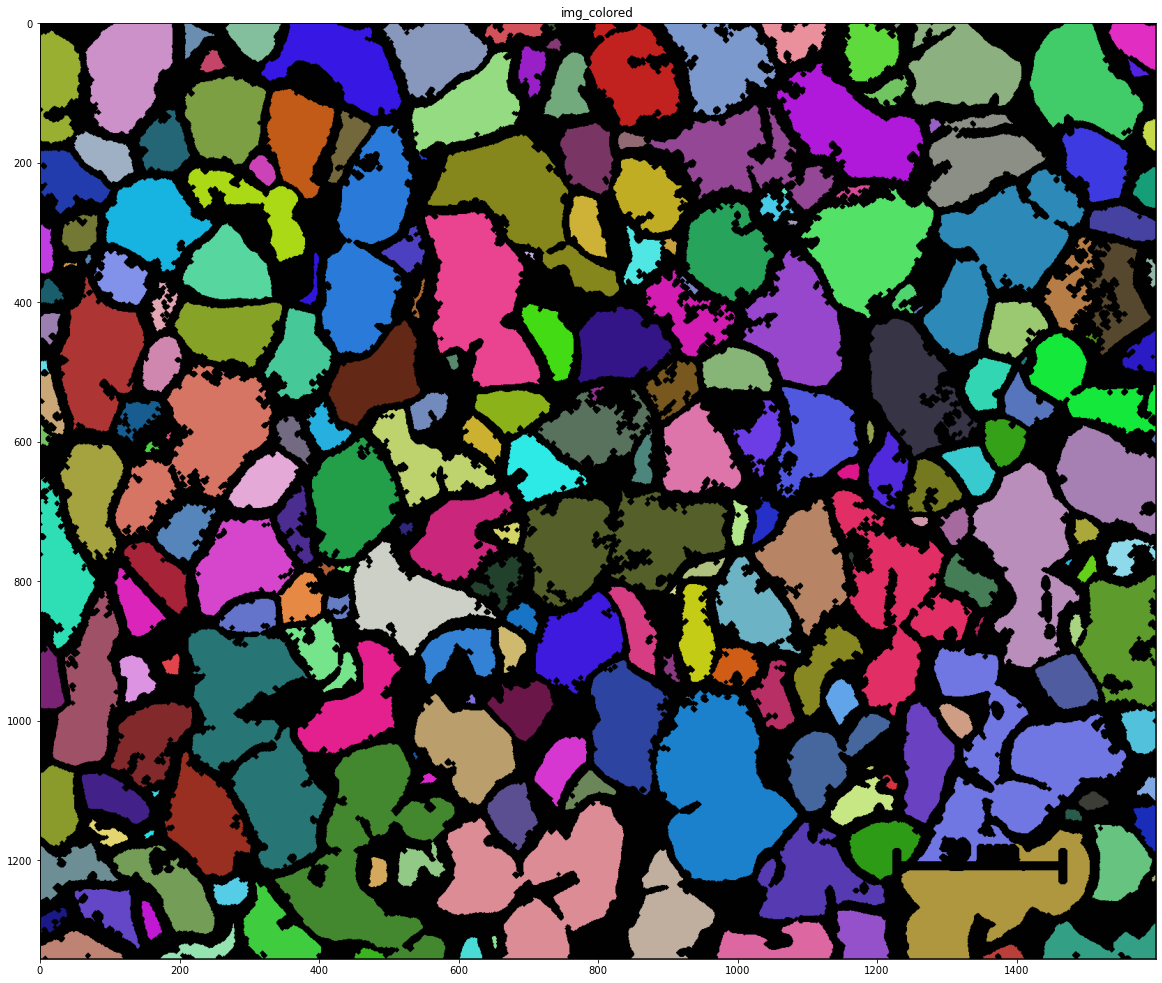

In [13]:
#Preenchendo contornos
img_colored = np.int32(np.ones(img.shape))
img_out = img.copy()
for c in contours:
    random_color = [np.random.randint(20, 235) for i in range(3)]
    img_colored = cv2.fillPoly(img_colored, [c], random_color)
    img_out = cv2.drawContours(img_out, [c], -1, random_color, 3)
    
if show: plt.figure(figsize=(20,20)); plt.title("img_colored"); fig = plt.imshow(img_colored, 'gray')

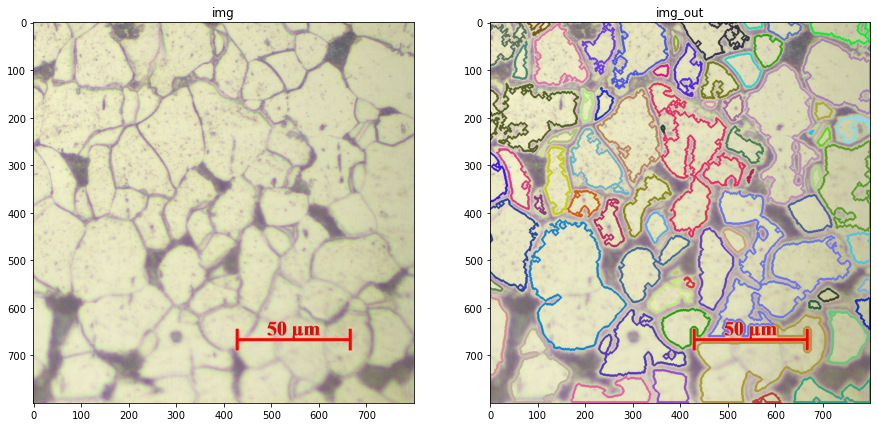

In [14]:
#Visualizando novamente
plt.figure(figsize= (15,15))
plt.subplot(121); plt.title('img'); fig=plt.imshow(img[-800:,-800:], 'gray')
plt.subplot(122); plt.title('img_out'); fig=plt.imshow(img_out[-800:,-800:], 'gray')

In [15]:
print("n_contours =", len(contours))
print("n_borda =", n_borda)
resultado = len(contours)-round(n_borda/2)
print("resultado =", resultado, "grãos")

n_contours = 237
n_borda = 55
resultado = 209 grãos


In [16]:
if n_real>0:
    print("n_real =", n_real)
    erro = abs(n_real-resultado)
    print("erro =", erro)